In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=transform)

Input shape: torch.Size([64, 1, 28, 28])
Labels: tensor([9, 8, 1, 6, 8, 6, 8, 8, 7, 3, 0, 1, 3, 8, 4, 7, 8, 9, 6, 1, 8, 2, 2, 3,
        4, 0, 6, 7, 4, 9, 2, 4, 1, 5, 7, 1, 9, 8, 6, 1, 0, 8, 6, 8, 7, 1, 6, 6,
        1, 5, 6, 6, 4, 0, 3, 7, 7, 5, 3, 0, 0, 8, 7, 9])


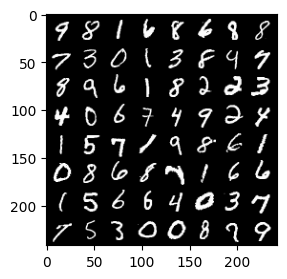

In [3]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)

plt.figure(figsize=(10,3))
plt.imshow(torchvision.utils.make_grid(x*0.5 + 0.5).permute(1,2,0).numpy())
plt.show()

# Forward Diffusion Process

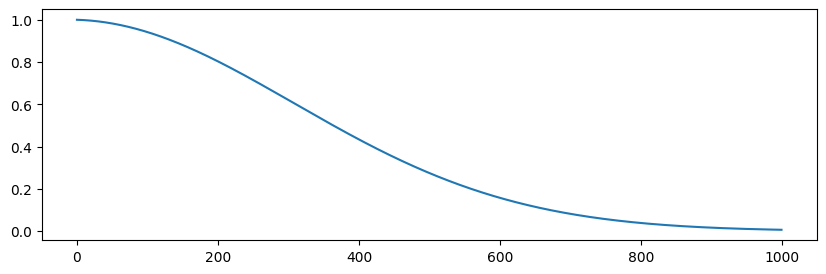

In [4]:
T = 1000
betas = torch.linspace(1e-4,0.01,T)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas,dim=0)

# plot the alpha bars
plt.figure(figsize=(10,3))
plt.plot(alpha_bars)
plt.show()

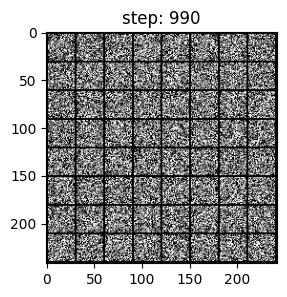

In [5]:
# Start the forward diffusion process

x=x.to(device)

for t in range(T):
    noise = torch.randn_like(x).to(device)
    
    alpha_bar = alpha_bars[t]
    x_t1 = torch.sqrt(alpha_bar)*x + torch.sqrt(1-alpha_bar) * noise
    
    if t%10==0:
        plt.figure(figsize=(10,3))
        plt.title(f'step: {t}')
        plt.imshow(torchvision.utils.make_grid(x_t1*0.5 + 0.5).permute(1,2,0).cpu().numpy())
        clear_output(wait=True)
        plt.show()
    


# Create A Unet

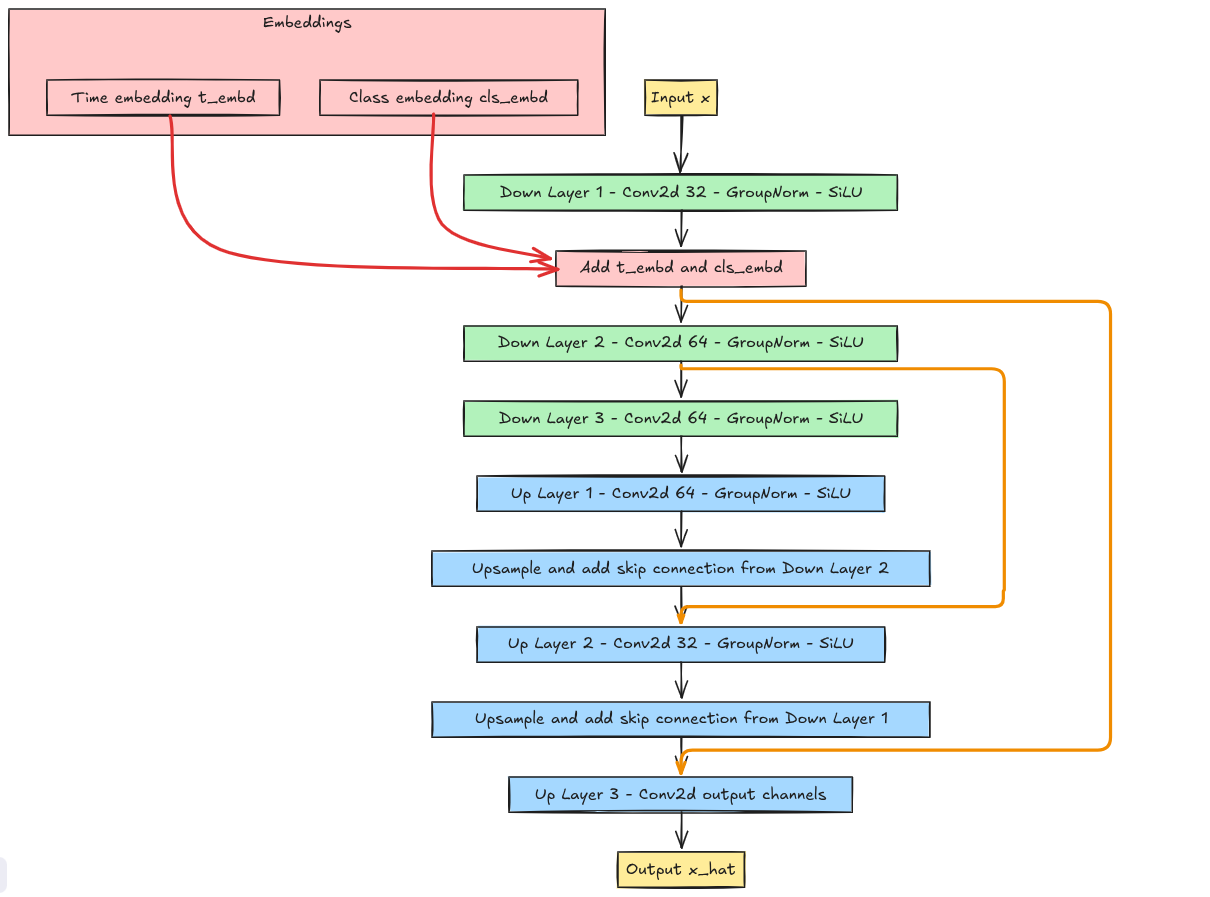

In [26]:
import torch
import torch.nn as nn

class MyUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        
        # ---- Down layers ----
        self.down_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.GroupNorm(1, 32),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
        ])
        
        # ---- Up layers ----
        self.up_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.GroupNorm(1, 64),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.GroupNorm(1, 32),
                nn.SiLU()
            ),
            nn.Sequential(
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2)
                # Output layer - no normalization, no activation
            ),
        ])
        
        # ---- Embedding layers ----
        self.time_embedding_layer = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32)
        )

        self.class_embedding_layer = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.LayerNorm(32)
        )

        # ---- Scaling operators ----
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t, cls):
        t = t.reshape(-1, 1).to(x.device)
        cls = cls.reshape(-1, 1).to(x.device)
        
        # Embedding
        t_embd = self.time_embedding_layer(t.float())
        cls_embd = self.class_embedding_layer(cls.float())
        
        # Downsampling path
        h = []
        for i, layer in enumerate(self.down_layers):
            x = layer(x)
            if i == 0:
                x = x + t_embd[:, :, None, None] + cls_embd[:, :, None, None]
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        # Upsampling path
        for i, layer in enumerate(self.up_layers):
            if i > 0:
                x = self.upscale(x)
                x = x + h.pop()
            x = layer(x)
        
        return x

In [27]:
unet = MyUNet().to(device)
x=torch.randn(5,1,28,28).to(device)
t = torch.linspace(0,999,5).reshape(-1,1).to(device)
cls = torch.randperm(5).reshape(-1,1).to(device)
unet(x,t,cls).shape

torch.Size([5, 1, 28, 28])

# Train the UNet

In [24]:
def generate_image():
    xt = torch.randn(10,1,28,28).to(device)
    y = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
    
    unet.eval()

    for tt in tqdm(range(T-1,-1,-1)):
        t = torch.tensor([tt]*10)
        with torch.no_grad():
            noise_pred = unet(xt,t,y)
            
        alpha_bar = alpha_bars[t][:,None,None,None].to(device)
        alpha = alphas[t][:,None,None,None].to(device)
        beta = betas[t][:,None,None,None].to(device)
        
        
        coef1 = 1 / torch.sqrt(alpha)
        coef2 = beta / torch.sqrt(1 - alpha_bar)
        mu_theta = coef1 * (xt - coef2 * noise_pred)
        
        if tt > 0:
            # Sample noise for the next step
            noise = torch.randn_like(xt).to(device)
            sigma_t = torch.sqrt(beta).to(device)  # or learned covariance
            xt = mu_theta + sigma_t * noise
        else:
            # At t=0, no noise added
            xt = mu_theta
    
    plt.figure(figsize=(10,3))
    plt.title(f'step:{step}')
    plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    plt.show()

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

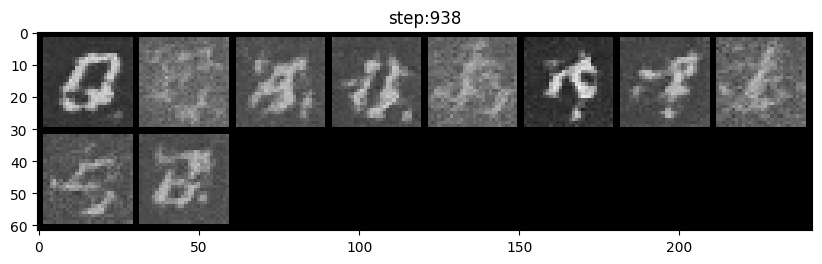

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027133226..1.0424777].


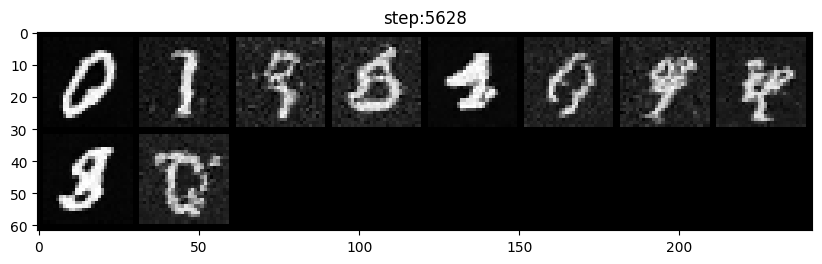

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11711371..1.0718036].


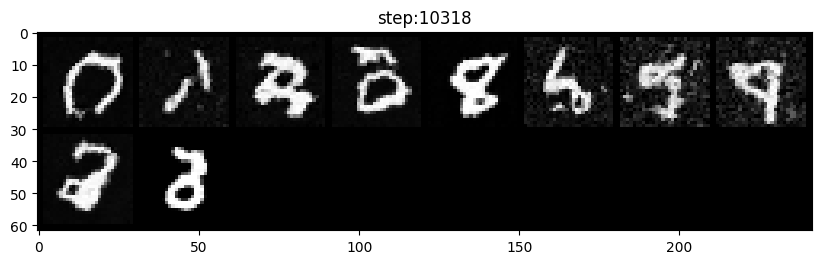

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.069652796..1.0751369].


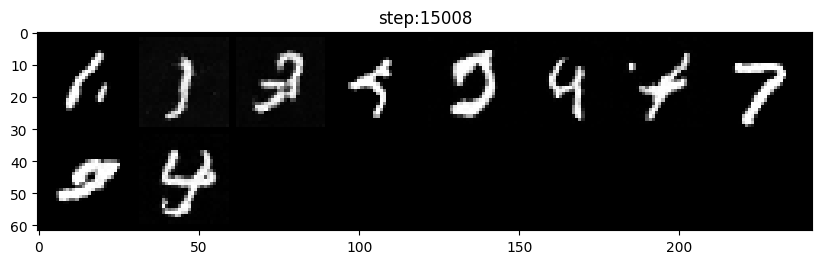

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06464267..1.0323796].


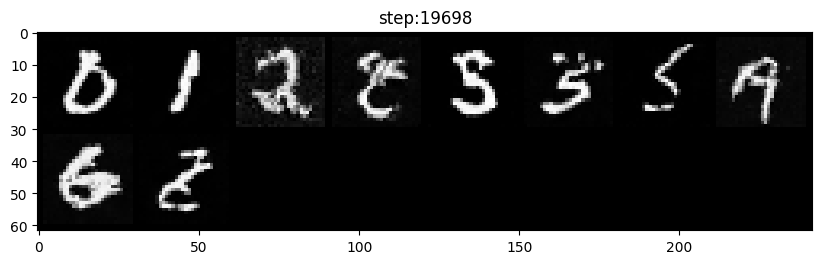

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10259849..1.0907905].


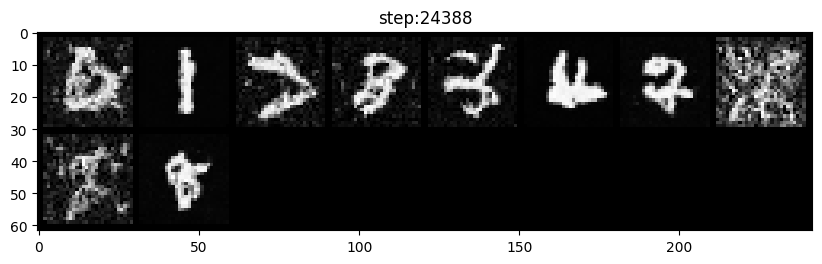

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08403051..1.0669713].


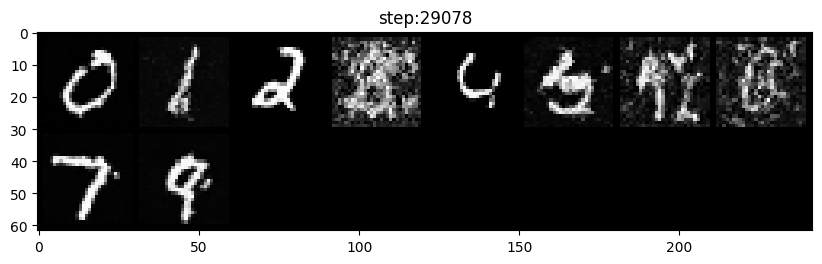

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07371771..1.086891].


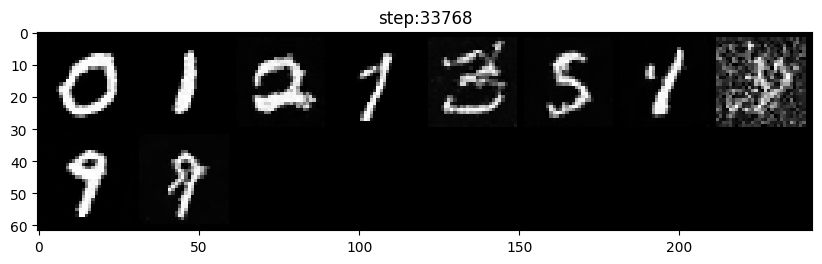

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019013584..1.0384063].


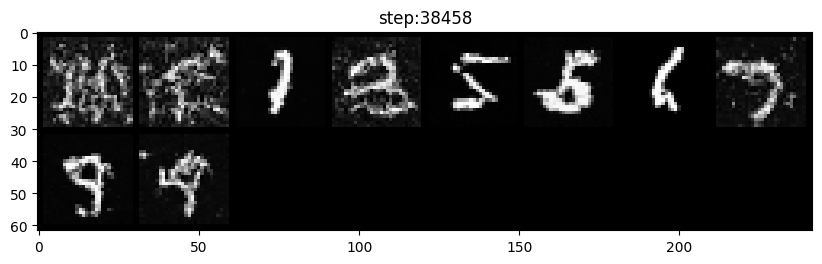

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.039874375..1.0858903].


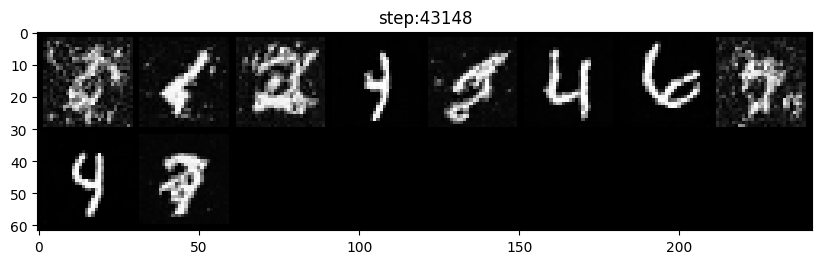

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [25]:
# sample training
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(unet.parameters(),lr=5e-4)

step=0

for epoch in range(50):
    for x,y in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        
        unet.train()
        
        x = x.to(device)
        
        t = torch.randint(0,T,(x.shape[0],))
        
        noise = torch.randn_like(x).to(device)

        alpha_bar = alpha_bars[t][:,None,None,None].to(device)
        x_t1 = torch.sqrt(alpha_bar)*x + torch.sqrt(1-alpha_bar) * noise

        pred = unet(x_t1,t,y)
        
        loss_val = loss_fn(pred,noise)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        step+=1
        
    if epoch%5==0:
        generate_image()
# Sample from the model
    


In [11]:
x_t1.max(),x_t1.min()

(tensor(3.9025, device='cuda:0'), tensor(-3.8137, device='cuda:0'))